# Executive summary
A trading strategy has been developed that in the backtest has a higher-risk adjusted return than 'buy-and-hold' of the underlying asset. However, the excess return is marginal. Also, many years are required before the prediction of expected returns becomes meaningful. Certain improvements could be made to have a better-performing options trading strategy.

# Introduction
## Aim
A backtest engine is produced in python in order to do research into automated options trading strategies. The following research questions are asked:

1. Is it possible to predict the expected return of an options trade?
2. Is it possible to use the prediction in 1 to find optimal trades, thereby producing an excess risk-adjusted return compared to 'buy-and-hold' of the underlying asset?

## Outline of analyses
The analysis is done in the following order:

1. The distribution of daily returns is modelled using historical data (before the start of the options data).
2. A backtest is run without optimization
3. A backtest is run with optimization.

Freely available daily historical data of SPY from OptionsDX is used.

## Details of backtest engine

1. Credit spread trades are performed.
2. The volatility is predicted using a Garch(1,1) model.
3. The backtest is started at the first date in the options data, and ended at the last date in the options data.
4. Trades are performed back-to-back. On the day that the one trade closes, the next trade opens. Trades are performed sequentially.
5. The expected return is computed based on the predicted standard deviation and a Student's t distribution (probabilistic expected value calculation).
6. The actual return is computed based on the price of the underlying asset at expiration.
7. Slippage is estimated by expecting a certain decrease in short prices and increase in long prices. The maximum of either a percentage change or absolute change (USD value) is used for each options price.
8. For the sake of simplicity, no exit strategy is used, such as profit-taking or stop-loss.
9. For the sake of simplicity, the only parameter varied during optimization is the number of days to expiration.

## Inputs

| Parameter | Value |
| --- | --- |
| Desired probability of maximum loss | 10 % |
| Distance between long and short trade | 1 strike price row |
| Minimum expected return required | 0 % |
| Capital allocated to trade | 10 % |
| Days to expiration desired | 7 days |
| Range of days to expiration during optimization | 1 - 22 days |
| Relative slippage | 0.5 % |
| Absolute slippage | 0.01 USD |

In [13]:
## Inputs true for all analyses
max_loss_probability = 10/100
spread_length = 1
alpha_required = 0
allocation_fraction = 1/10
DTE_min = 7
DTE_max = 22
slippage_per = 0.5
slippage_abs = 0.01

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import yfinance as yf
from scipy.stats import norm, lognorm, t, cauchy, weibull_min

import warnings
warnings.filterwarnings("ignore")

plt.rcParams.update({'font.size': 18})

In [3]:
# Functions
def cumulative_average(arr):
    
    cumulative_sum = 0
    count = 0
    result = np.empty_like(arr)

    for i, val in enumerate(arr):
        
        if not np.isnan(val):
            cumulative_sum += val
            count += 1
        if count > 0:
            result[i] = cumulative_sum / count
        else:
            result[i] = np.nan

    return result

def sharpe_calc(price_df):

    prices = np.array(price_df)
    returns = np.diff(prices)
    mean = np.mean(returns)
    stdev = np.std(returns)
    sharpe = mean/stdev

    return sharpe * np.sqrt(252)

# Analysis

In [4]:
ticker = "SPY"

## Step 1: Distribution

[*********************100%%**********************]  1 of 1 completed


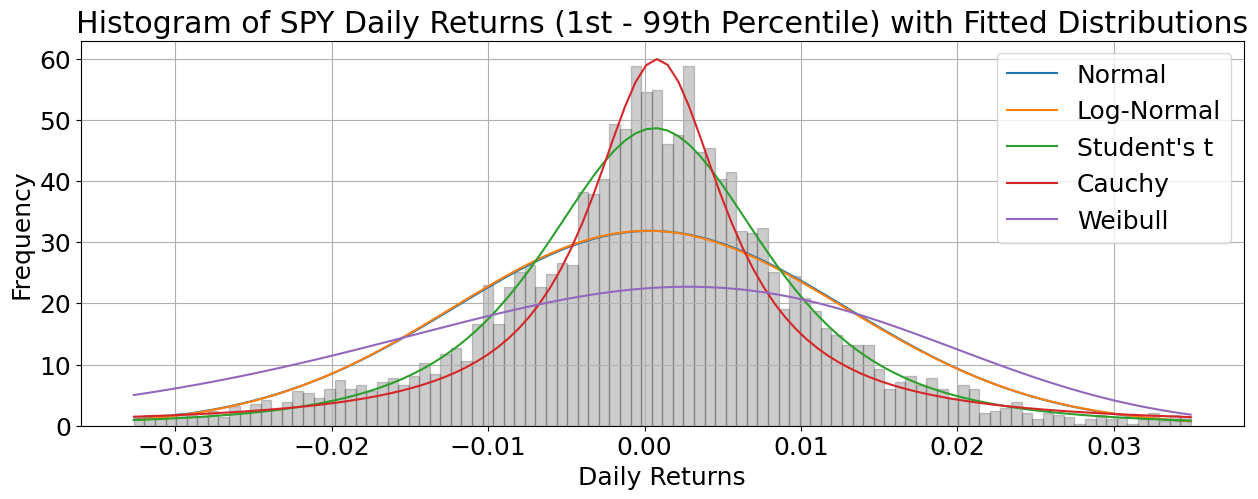

Student's t degrees of freedom: 2.82


In [5]:
# Step 1: Data Retrieval
start_date = "1900-01-01"
end_date = "2009-12-31"
data = yf.download(ticker, start=start_date, end=end_date)
adj_close = data['Adj Close']

# Step 2: Calculate daily returns
daily_returns = adj_close.pct_change().dropna()

# Calculate 1st and 99th percentiles
percentile_1 = np.percentile(daily_returns, 1)
percentile_99 = np.percentile(daily_returns, 99)

# Filter data to include only values within 1st and 99th percentiles
filtered_data = daily_returns[(daily_returns >= percentile_1) & (daily_returns <= percentile_99)]

# Step 3: Plot Histogram of Daily Returns
plt.figure(figsize=(15, 5))
plt.hist(filtered_data, bins=100, alpha=0.2, density=True, color='k', edgecolor='black')

# Step 4 & 5: Fit Distributions and Plot
distributions = {'Normal': norm, 'Log-Normal': lognorm, 'Student\'s t': t,
                 'Cauchy': cauchy, 'Weibull': weibull_min}

for name, dist in distributions.items():
    try:
        params = dist.fit(daily_returns)
        
        # Extract degrees of freedom parameter (t_df)
        if name == "Student's t":
            t_df = params[0]
            t_loc = params[1]
        
        fitted_distribution = dist(*params)
        x = np.linspace(min(filtered_data), max(filtered_data), 100)
        plt.plot(x, fitted_distribution.pdf(x), label=name)

    except:
        print(f"Could not fit distribution {name}")

# Plot
plt.title('Histogram of SPY Daily Returns (1st - 99th Percentile) with Fitted Distributions')
plt.xlabel('Daily Returns')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

# Now, you can use the t_df parameter as needed
print("Student's t degrees of freedom:", round(t_df,2))

**Discussion:**

The Student's t distribution is used, as it fits the histogram across the different regions the best. This is to be expected, as equity returns typically have 'fatter tails' than that given by a normal distribution.

## Step 2: Backtest without optimization

In [14]:
# Start conditions
capital_available_start = 10000
start_date = np.datetime64('2010-01-01')

# Pre-processing
options_df = pd.read_pickle("options_data_SPY.pkl")
options_df = options_df[(options_df['[DTE]'] >= DTE_min) & (options_df['[DTE]'] <= DTE_max)]
price_df = pd.read_pickle("underlying_data_SPY.pkl")
returns_df = pd.read_pickle("returns_data_SPY.pkl")

In [15]:
# Import function
from basic_backtest import backtest_func

current_date_vect, capital_available_vect, ROR_actual_vect, ROR_expect_vect = \
    backtest_func(options_df, price_df, returns_df, start_date, alpha_required,\
                  max_loss_probability, allocation_fraction,\
                    capital_available_start, spread_length,\
                        slippage_abs, slippage_per, t_df)

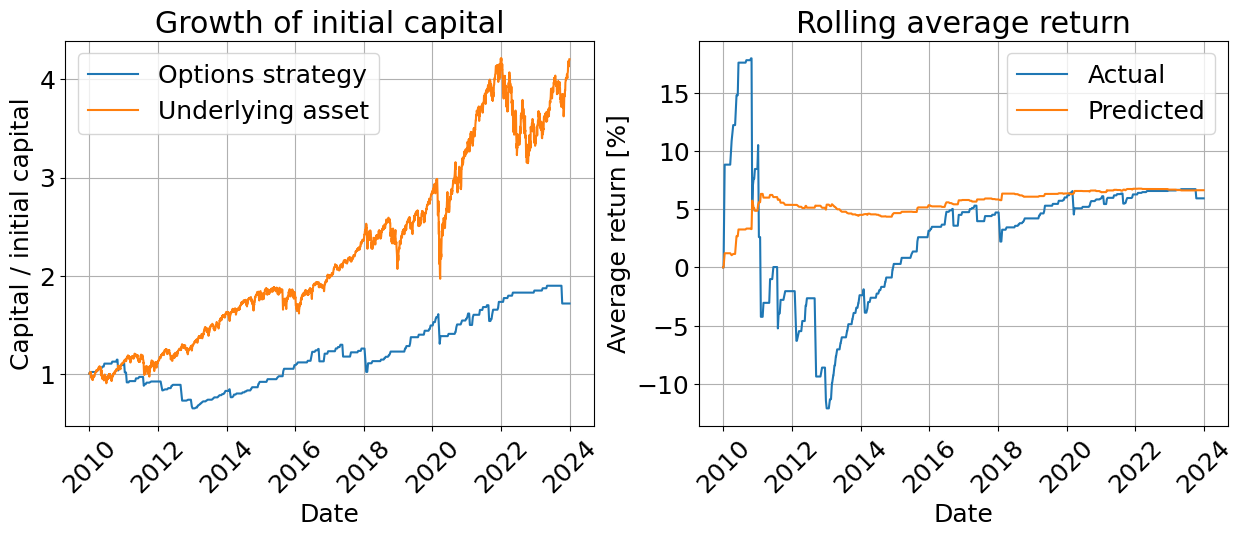

Sharpe Ratio of underlying asset: 0.54
Sharpe Ratio of options strategy: 0.3


In [16]:
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
plt.plot(current_date_vect, capital_available_vect/capital_available_start, label='Options strategy')
plt.plot(price_df['Date'], price_df['Price']/price_df['Price'].iloc[0], label='Underlying asset')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Capital / initial capital')
plt.title('Growth of initial capital')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(current_date_vect, cumulative_average(ROR_actual_vect), label='Actual')
plt.plot(current_date_vect, cumulative_average(ROR_expect_vect), label='Predicted')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average return [%]')
plt.title('Rolling average return')
plt.xticks(rotation=45)

plt.show()

print('Sharpe Ratio of underlying asset:', round(sharpe_calc(price_df['Price']),2))
print('Sharpe Ratio of options strategy:', round(sharpe_calc(capital_available_vect),2))

**Discussion:**

1. The risk-adjusted return of the fixed arbitrary options trading strategy is lower than that of 'buy-and-hold' of the underlying asset.
2. Towards the end of the test period, the expected and actual returns converge. This is to be expected, as the predicted return is probabilistic in nature, and is only meaningful after a large number of trades.

## Step 3: Backtest with optimization

In [10]:
# Import function
from optimization_DTE import backtest_func

# Changed parameters
DTE_min = 1
optimization_paramaters = [DTE_min,DTE_max,spread_length,max_loss_probability]

# Pre-processing
options_df = pd.read_pickle("options_data_SPY.pkl")
options_df = options_df[(options_df['[DTE]'] >= DTE_min) & (options_df['[DTE]'] <= DTE_max)]
price_df = pd.read_pickle("underlying_data_SPY.pkl")
returns_df = pd.read_pickle("returns_data_SPY.pkl")

current_date_vect, capital_available_vect, ROR_actual_vect, ROR_expect_vect = \
    backtest_func(options_df, price_df, returns_df, start_date, alpha_required,\
                  allocation_fraction, capital_available_start,\
                        slippage_abs, slippage_per, t_df, optimization_paramaters)

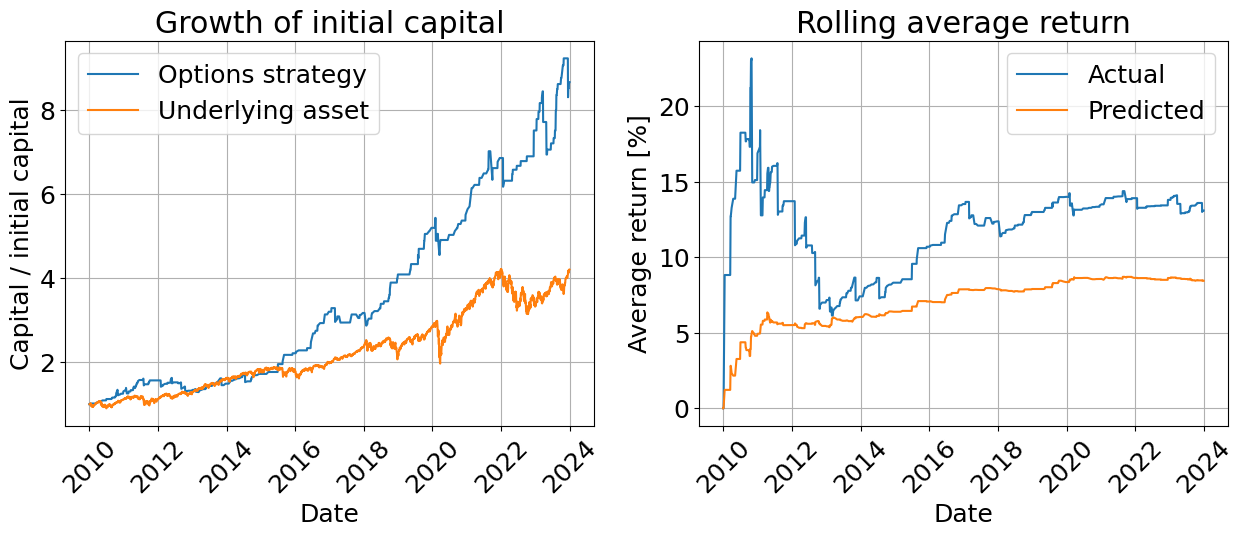

Sharpe Ratio of underlying asset: 0.54
Sharpe Ratio of options strategy: 0.78


In [12]:
plt.figure(figsize=[15,5])

plt.subplot(1,2,1)
plt.plot(current_date_vect, capital_available_vect/capital_available_start, label='Options strategy')
plt.plot(price_df['Date'], price_df['Price']/price_df['Price'].iloc[0], label='Underlying asset')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Capital / initial capital')
plt.title('Growth of initial capital')
plt.xticks(rotation=45)

plt.subplot(1,2,2)
plt.plot(current_date_vect, cumulative_average(ROR_actual_vect), label='Actual')
plt.plot(current_date_vect, cumulative_average(ROR_expect_vect), label='Predicted')
plt.grid()
plt.legend()
plt.xlabel('Date')
plt.ylabel('Average return [%]')
plt.title('Rolling average return')
plt.xticks(rotation=45)

plt.show()

print('Sharpe Ratio of underlying asset:', round(sharpe_calc(price_df['Price']),2))
print('Sharpe Ratio of options strategy:', round(sharpe_calc(capital_available_vect),2))

**Discussion:**

1. The risk-adjusted return of the optimizing options trading strategy is higher than that of 'buy-and-hold' of the underlying asset.
2. Towards the end of the test period, the expected and actual returns have a constant difference. This error could be because the volatility prediction used becomes less accurate with longer trade lengths (number of days to expiration).

# Concluding remarks
## Conclusion
A trading strategy has been developed that in the backtest has a higher-risk adjusted return than 'buy-and-hold' of the underlying asset. However, the excess return is marginal. Also, many years are required before the prediction of expected returns becomes meaningful. Certain improvements could be made to have a better-performing options trading strategy.

## Recommendations
Such a trading strategy, where trades are performed back-to-back, should not be employed. Instead, more frequent trading should be performed, with a significant number of trades performed simultaneously, in order to have greater trust in the expected return prediction.

## Future work
The following areas can be improved:

1. A volatility prediction model suitable for longer timeframes should be used.
2. Research should be done into optimization of exit parameters, such as profit-taking and stop-loss. This could make a significant difference to the strategy's performance if options are priced assuming they are held to expiration (such as Black-Scholes being based on European options).
3. Backtests should be performed on other equity ETF's as well (out-of-sample tests).